# System State in the Temperature-Entropy Diagram
To always have a well-defined temperature for the system we need *diagonal* states throughout the evolution.
This is guarantee by the dynamical map if the system starts from a diagonal state.

In [1]:
import glob
from IPython.display import display, Image
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from qutip.visualization import plot_fock_distribution, plot_wigner

import tqdm

import uuid
import json
import os

from thermophaseonium.utilities.make_gif import create_gif
from thermophaseonium.utilities.states import Cavity, Ancilla

SEED = 42
rng = np.random.default_rng(SEED)

OMEGA = 0.5  # Interaction strength
N = 50  # Maximum number of dimensions

INTERACTION_TIME = 0.01
T_MAX = 1000
TIMESTEPS = np.linspace(0, T_MAX, int(T_MAX / INTERACTION_TIME))
print(f"Total of {len(TIMESTEPS)} timesteps from 0 to {T_MAX} with dt = {INTERACTION_TIME}")

Total of 100000 timesteps from 0 to 1000 with dt = 0.01


In [2]:
n_photons = 1
system = Cavity(qt.thermal_dm(N, n_photons), omega=1)

alpha = np.sqrt(0.4)
chi01_phase = np.pi * 0
chi02_phase = np.pi * 1
chi12_phase = np.pi * 0
chi01 = np.cos(chi01_phase) + 1j * np.sin(chi01_phase)
chi02 = np.cos(chi02_phase) + 1j * np.sin(chi02_phase)
chi12 = np.cos(chi12_phase) + 1j * np.sin(chi12_phase)

ancilla = Ancilla([
    [alpha**2, chi01, chi02],
    [chi01.conjugate(), (1 - alpha**2)/2, chi12],
    [chi02.conjugate(), chi12.conjugate(), (1 - alpha**2)/2]
])
print(ancilla.stable_temperature)
ancilla

2.059699076913792


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.4+0.0000000e+00j  1. +0.0000000e+00j -1. +1.2246468e-16j]
 [ 1. +0.0000000e+00j  0.3+0.0000000e+00j  1. +0.0000000e+00j]
 [-1. -1.2246468e-16j  1. +0.0000000e+00j  0.3+0.0000000e+00j]]

## Evolution

In [3]:
def H_work(ancilla, omega=OMEGA):
    chi01 = ancilla.chi01
    chi02 = ancilla.chi02
    a = qt.destroy(N)
    upshift = (chi01 + chi02) * a.dag()
    return omega * (upshift + upshift.dag())

In [4]:
def D(op1, rho, op2=None):
    if op2 is None:
        op2 = op1
    return op1 * rho * op2.dag() - qt.commutator(op2.dag() * op1, rho, kind='anti') / 2

In [5]:
def onestep_evolution(rho, eta, dt=INTERACTION_TIME, o=OMEGA):
    work = 1j * o * dt * qt.commutator(H_work(eta), rho)
    heat1 = eta.ga * ( o * dt ) ** 2 * D(qt.create(N), rho)
    heat2 = eta.gb * ( o * dt ) ** 2 * D(qt.destroy(N), rho)
    rho_new = rho + work + heat1 + heat2
    return rho_new

In [6]:
def hilbert_is_good(rho, threshold=1e-6):
    """
    Check if the last element of the density matrix is almost null
    :param rho:
    :return:
    """
    return 0 <= abs(rho[-1, -1]) < threshold

In [7]:
def new_ancilla(ancilla, method='static', **kwargs):
    if method == 'static':
        return ancilla
    elif method == 'rotating':
        phis = np.linspace(0, 2 * np.pi, kwargs.get('timesteps', 10))
        ancilla.chi01 = phis[kwargs.get('step', -1)]
        ancilla.chi02 = phis[kwargs.get('step', -1)]
        return ancilla
    else:
        raise ValueError(f"Method {method} not recognized")


In [8]:
rho = system
temperature_evolution = np.zeros(len(TIMESTEPS))
entropy_evolution = np.zeros(len(TIMESTEPS))
time_evolution = np.zeros(len(TIMESTEPS))

for k, t in enumerate(tqdm.tqdm(TIMESTEPS)):
    eta_k = ancilla
    rho_new = onestep_evolution(rho, eta_k)
    rho = Cavity(rho_new)
    time_evolution[k] = t
    try:
        temperature_evolution[k] = rho.temperature
        entropy_evolution[k] = rho.entropy
    except TypeError as e:
        print(f"Error in computing observables at step {k} with t = {t}: {e}")
        break
    if not hilbert_is_good(rho):
        print(f"Approximation no more valid at step {k} with t = {t}")
        break

rho = Cavity(rho)

100%|██████████| 100000/100000 [04:03<00:00, 410.11it/s]


In [100]:
def ancilla_text(ancilla_obj):
    alpha = np.round(ancilla_obj.alpha**2, 3)
    chi01 = np.round(ancilla_obj.chi01, 3)
    chi02 = np.round(ancilla_obj.chi02, 3)
    chi12 = np.round(ancilla_obj.chi12, 3)
    beta = np.round(ancilla_obj.beta**2, 3)
    return (
        r"\begin{eqnarray*}"
        r"\textbf{Ancilla} \\"
       f"{alpha} & {chi01} & {chi02}" r"\\"
       f"{chi01.conjugate()} & {beta} & {chi12}" r"\\"
       f"{chi02.conjugate()} & {chi12.conjugate()} & {beta}"
       r"\end{eqnarray*}")

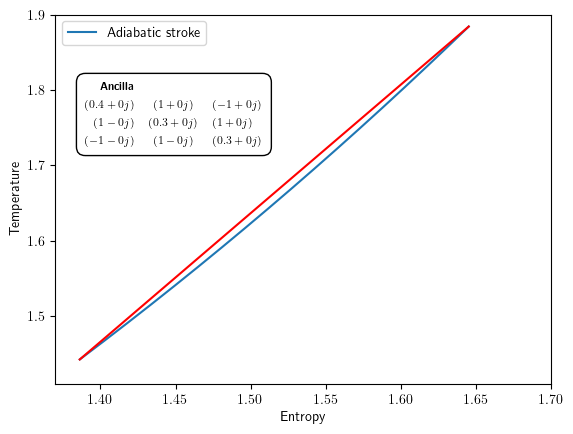

In [105]:
plt.plot(entropy_evolution, temperature_evolution, label='Adiabatic stroke')
plt.plot([entropy_evolution[0], entropy_evolution[-1]], [temperature_evolution[0], temperature_evolution[-1]], 'r')
plt.xlabel('Entropy')
plt.ylabel('Temperature')
plt.xlim(1.37, 1.7)
plt.ylim(1.41, 1.9)
plt.text(1.39, 1.8, ancilla_text(ancilla), fontsize=8, bbox=dict(boxstyle="round", fc="white", ec="black", pad=0.8))
plt.legend()
plt.savefig("../visualization/ts_plane/adiabatic_stroke.png")
plt.show()